## Getting setup

As we've done previously, let's make sure we've got all of the modules we'll need for this section.

We'll import the Python scripts (such as `data_setup.py` and `engine.py`) we created in [ PyTorch Going Modular](https://github.com/NANDAGOPALNG/pytorch--going_modular).

To do so, we'll download [`going_modular`](https://github.com/NANDAGOPALNG/pytorch--going_modular/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available.

`torchinfo` will help later on to give us a visual representation of our model.

And since later on we'll be using `torchvision`

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/NANDAGOPALNG/pytorch--going_modular
    !mv pytorch--going_modular/going_modular .
    !mv pytorch--going_modular/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch--going_modular
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch--going_modular'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 53 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 17.77 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

I have downloaded the dataset from -- https://www.cs.toronto.edu/%7Ekriz/cifar.html

In [5]:
from torchvision import transforms

# Enhanced data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
train_dir = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dir = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


In [7]:
# Set the batch size
BATCH_SIZE = 128 # this is lower than the ViT paper but it's because we're starting small
IMG_SIZE = 32

# Create data loaders
train_dataloader = DataLoader(train_dir,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_dir,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

class_names = train_dir.classes

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f4cbe0f06e0>,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 32, 32]), tensor(2))

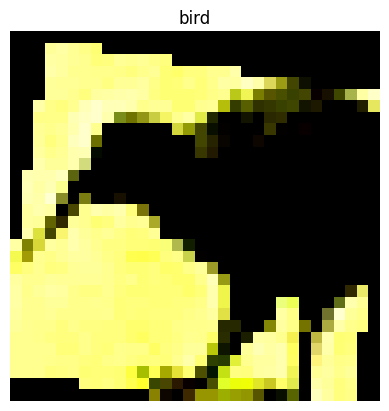

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Replicating the ViT paper

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendix B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

####  Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*



| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |


*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

Calculating patch embedding input and output shapes by hand

In [10]:
# Create example values
height = 32 # H
width = 32 # W
color_channels = 3 # C
patch_size = 4 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=32), width (W=32) and patch size (P=4): 64


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (32, 32, 3)
Output shape (single 2D image flattened into patches): (64, 48)


Turning a single image into patches

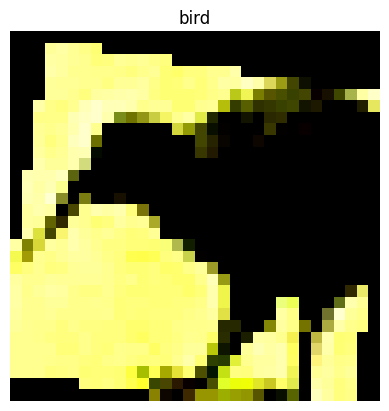

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

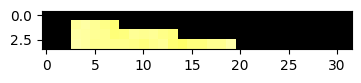

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 4
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 8.0
Patch size: 4 pixels x 4 pixels


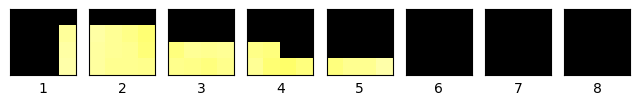

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 32
patch_size = 4
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 8.0        
Number of patches per column: 8.0        
Total patches: 64.0        
Patch size: 4 pixels x 4 pixels


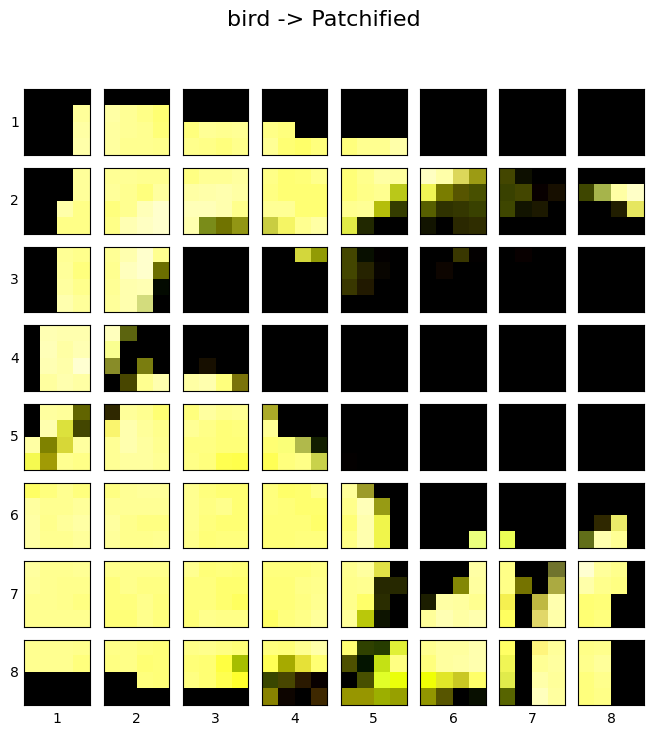

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 32
patch_size = 4
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Creating image patches with torch.nn.Conv2d()

In [16]:
from torch import nn

# Set the patch size
patch_size=4

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=256,
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

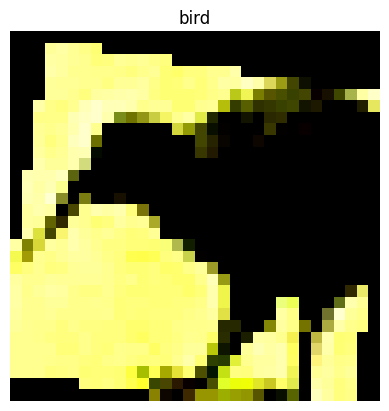

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 256, 8, 8])


torch.Size([1, 256, 8, 8]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indexes: [199, 208, 178, 254, 27]


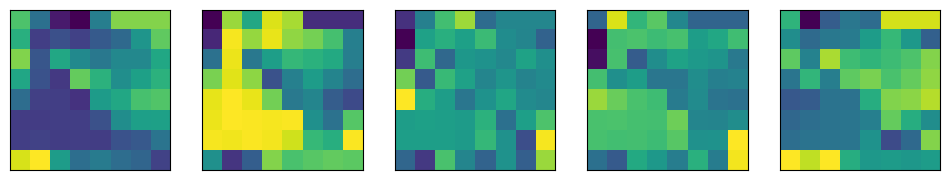

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 256), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 1.5073,  1.3538,  2.2951,  2.3861,  2.4939,  1.0852,  1.0852,
            1.0852],
          [ 1.3114, -0.0153, -0.3876,  0.0269, -0.4627, -0.1620,  0.6866,
            0.9404],
          [ 1.5317, -0.3553,  0.6873,  0.5250,  0.3578,  0.4207,  0.5423,
            0.4543],
          [ 1.3322,  0.4958,  1.8218,  0.4319,  0.6434,  0.5923,  0.4698,
            0.6093],
          [ 0.7963,  0.1672, -0.0449,  0.9976,  1.0759,  0.5612,  0.7002,
            0.6727],
          [ 0.0102, -0.0398,  0.0260,  0.0769,  0.1780,  1.0184,  1.0262,
            1.9150],
          [-0.0269,  0.0132,  0.0558,  0.0379, -0.2125,  1.4918, -0.0198,
           -0.3097],
          [-1.2016, -1.2991, -1.2949, -0.2323,  0.6060, -0.4433,  0.1490,
           -0.4307]]], grad_fn=<SliceBackward0>),
 True)

Flattening the patch embedding with torch.nn.Flatten()

In [21]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 256, 8, 8]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [22]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 32, 32])
Image feature map shape: torch.Size([1, 256, 8, 8])
Flattened image feature map shape: torch.Size([1, 256, 64])


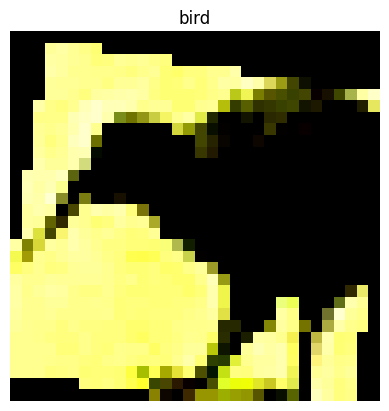

In [23]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 64, 256]) -> [batch_size, num_patches, embedding_size]


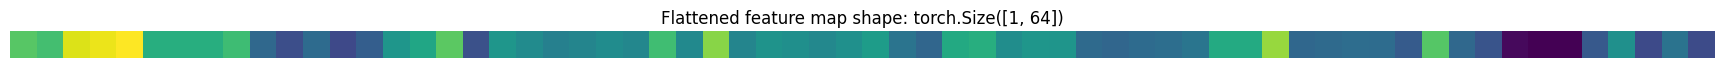

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [26]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 1.5073,  1.3538,  2.2951,  2.3861,  2.4939,  1.0852,  1.0852,  1.0852,
           1.3114, -0.0153, -0.3876,  0.0269, -0.4627, -0.1620,  0.6866,  0.9404,
           1.5317, -0.3553,  0.6873,  0.5250,  0.3578,  0.4207,  0.5423,  0.4543,
           1.3322,  0.4958,  1.8218,  0.4319,  0.6434,  0.5923,  0.4698,  0.6093,
           0.7963,  0.1672, -0.0449,  0.9976,  1.0759,  0.5612,  0.7002,  0.6727,
           0.0102, -0.0398,  0.0260,  0.0769,  0.1780,  1.0184,  1.0262,  1.9150,
          -0.0269,  0.0132,  0.0558,  0.0379, -0.2125,  1.4918, -0.0198, -0.3097,
          -1.2016, -1.2991, -1.2949, -0.2323,  0.6060, -0.4433,  0.1490, -0.4307]],
        grad_fn=<SelectBackward0>),
 True,
 torch.Size([1, 64]))

Turning the ViT patch embedding layer into a PyTorch module

In [27]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=4,
                 embedding_dim:int=256):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [28]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=4,
                          embedding_dim=256)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 32, 32])
Output patch embedding shape: torch.Size([1, 64, 256])


In [29]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-1.8132,  0.0812,  1.7669,  ...,  0.9012, -0.1780, -0.0945],
         [-1.3104,  0.7115, -1.6923,  ..., -0.5005, -0.0353, -0.6663],
         [-1.4749,  0.2351,  0.0861,  ...,  0.8336, -1.8441,  0.9895],
         ...,
         [ 0.5487, -0.3081, -1.6749,  ..., -0.7375,  0.8463, -0.6234],
         [ 0.7071, -0.0122, -0.9877,  ..., -0.4279,  0.1525, -0.7707],
         [-0.8118,  0.1223,  0.7920,  ...,  0.7446, -0.4360, -0.0026]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 64, 256]) -> [batch_size, number_of_patches, embedding_dimension]


In [30]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 256]) -> [batch_size, number_of_tokens, embedding_dimension]


In [31]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-1.8132,  0.0812,  1.7669,  ...,  0.9012, -0.1780, -0.0945],
         [-1.3104,  0.7115, -1.6923,  ..., -0.5005, -0.0353, -0.6663],
         ...,
         [ 0.5487, -0.3081, -1.6749,  ..., -0.7375,  0.8463, -0.6234],
         [ 0.7071, -0.0122, -0.9877,  ..., -0.4279,  0.1525, -0.7707],
         [-0.8118,  0.1223,  0.7920,  ...,  0.7446, -0.4360, -0.0026]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 65, 256]) -> [batch_size, number_of_patches, embedding_dimension]


Creating the position embedding

In [32]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.8132,  0.0812,  1.7669,  ...,  0.9012, -0.1780, -0.0945],
          [-1.3104,  0.7115, -1.6923,  ..., -0.5005, -0.0353, -0.6663],
          ...,
          [ 0.5487, -0.3081, -1.6749,  ..., -0.7375,  0.8463, -0.6234],
          [ 0.7071, -0.0122, -0.9877,  ..., -0.4279,  0.1525, -0.7707],
          [-0.8118,  0.1223,  0.7920,  ...,  0.7446, -0.4360, -0.0026]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 65, 256]))

In [33]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 65, 256]) -> [batch_size, number_of_patches, embedding_dimension]


In [34]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [-0.8132,  1.0812,  2.7669,  ...,  1.9012,  0.8220,  0.9055],
         [-0.3104,  1.7115, -0.6923,  ...,  0.4995,  0.9647,  0.3337],
         ...,
         [ 1.5487,  0.6919, -0.6749,  ...,  0.2625,  1.8463,  0.3766],
         [ 1.7071,  0.9878,  0.0123,  ...,  0.5721,  1.1525,  0.2293],
         [ 0.1882,  1.1223,  1.7920,  ...,  1.7446,  0.5640,  0.9974]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 65, 256]) -> [batch_size, number_of_patches, embedding_dimension]


Putting it all together: from image to embedding

In [35]:
set_seeds()

# 1. Set patch size
patch_size = 4

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=256)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 32, 32])
Input image with batch dimension shape: torch.Size([1, 3, 32, 32])
Patching embedding shape: torch.Size([1, 64, 256])
Class token embedding shape: torch.Size([1, 1, 256])
Patch embedding with class token shape: torch.Size([1, 65, 256])
Patch and position embedding shape: torch.Size([1, 65, 256])


Equation 2: Multi-Head Attention (MSA)

The LayerNorm (LN) layer

The Multi-Head Self Attention (MSA) layer

Replicating Equation 2 with PyTorch layers

In [36]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=256, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=8, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0.1): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [37]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=256, # from Table 1
                                                             num_heads=8) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 65, 256])
Output shape MSA block: torch.Size([1, 65, 256])


Equation 3: Multilayer Perceptron (MLP)

Replicating Equation 3 with PyTorch layers

In [38]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=256, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=512, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [39]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=256, # from Table 1
                     mlp_size=512, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 65, 256])
Output shape MLP block: torch.Size([1, 65, 256])


Create the Transformer Encoder

Creating a Transformer Encoder by combining our custom made layers

In [40]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=256, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=8, # Heads from Table 1 for ViT-Base
                 mlp_size:int=512, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x # Fix: Assign the result back to x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x # Return the output of the block

In [41]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
         input_size=(1, 65, 256), # (batch_size, num_patches, embedding_dimension)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 65, 256]         [1, 65, 256]         --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 65, 256]         [1, 65, 256]         --                   True
│    └─LayerNorm (layer_norm)                      [1, 65, 256]         [1, 65, 256]         512                  True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 65, 256]         263,168              True
├─MLPBlock (mlp_block)                             [1, 65, 256]         [1, 65, 256]         --                   True
│    └─LayerNorm (layer_norm)                      [1, 65, 256]         [1, 65, 256]         512                  True
│    └─Sequential (mlp)                            [1, 65, 256]         [1, 65, 256]         --                   True
│    │    └─Linear (0)                     

Creating a Transformer Encoder with PyTorch's Transformer layers

In [42]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=256, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=8, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=512, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (linear1): Linear(in_features=256, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [43]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 65, 256), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 65, 256]         [1, 65, 256]         --                   True
├─LayerNorm (norm1)                                [1, 65, 256]         [1, 65, 256]         512                  True
├─MultiheadAttention (self_attn)                   [1, 65, 256]         [1, 65, 256]         263,168              True
├─Dropout (dropout1)                               [1, 65, 256]         [1, 65, 256]         --                   --
├─LayerNorm (norm2)                                [1, 65, 256]         [1, 65, 256]         512                  True
├─Linear (linear1)                                 [1, 65, 256]         [1, 65, 512]         131,584              True
├─Dropout (dropout)                                [1, 65, 512]         [1, 65, 512]         --                   --
├─Linear (linear2)                             

Putting it all together to create ViT

In [44]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=32, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=4, # Patch size
                 num_transformer_layers:int=8, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=256, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=512, # MLP size from Table 1 for ViT-Base
                 num_heads:int=8, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [45]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 128
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 256)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 256])
Shape of class token embedding expanded: torch.Size([128, 1, 256])


In [46]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(128, 3, 32, 32) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.4507,  0.0631,  0.5796,  ..., -0.9570,  0.7591, -0.2505],
        [-0.3665,  0.0729,  0.9038,  ..., -0.5545,  0.5811, -0.1363],
        [-0.2450, -0.2561,  0.5259,  ..., -0.6108,  0.5411,  0.1714],
        ...,
        [-0.3274, -0.1181,  0.8552,  ..., -0.7302,  0.2479, -0.3989],
        [-0.2731, -0.0120,  0.5579,  ..., -0.4843,  0.7512, -0.2332],
        [-0.0619, -0.5508,  0.7139,  ..., -0.5400,  0.4947, -0.2643]],
       grad_fn=<AddmmBackward0>)

In [47]:
from torchinfo import summary

 # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(128, 3, 32, 32), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [128, 3, 32, 32]     [128, 10]            16,896               True
├─PatchEmbedding (patch_embedding)                           [128, 3, 32, 32]     [128, 64, 256]       --                   True
│    └─Conv2d (patcher)                                      [128, 3, 32, 32]     [128, 256, 8, 8]     12,544               True
│    └─Flatten (flatten)                                     [128, 256, 8, 8]     [128, 256, 64]       --                   --
├─Dropout (embedding_dropout)                                [128, 65, 256]       [128, 65, 256]       --                   --
├─Sequential (transformer_encoder)                           [128, 65, 256]       [128, 65, 256]       --                   True
│    └─TransformerEncoderBlock (0)                           [128, 65, 256]       [128, 65, 256]

Setting up training code for our ViT model

In [48]:
from going_modular.going_modular import engine

# Setup optimizer and loss function
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    params=vit.parameters(),
    lr=3e-4,
    weight_decay=0.05
)

# Set the seeds
set_seeds()

# Train the model - pass OPTIMIZER not scheduler
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,  # ← Pass optimizer here
    loss_fn=criterion,
    epochs=40,
    device=device
)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8172 | train_acc: 0.3337 | test_loss: 1.4961 | test_acc: 0.4610
Epoch: 2 | train_loss: 1.5497 | train_acc: 0.4403 | test_loss: 1.3849 | test_acc: 0.5078
Epoch: 3 | train_loss: 1.4386 | train_acc: 0.4813 | test_loss: 1.2476 | test_acc: 0.5477
Epoch: 4 | train_loss: 1.3661 | train_acc: 0.5079 | test_loss: 1.2195 | test_acc: 0.5675
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.5341 | test_loss: 1.1605 | test_acc: 0.5825
Epoch: 6 | train_loss: 1.2508 | train_acc: 0.5505 | test_loss: 1.1206 | test_acc: 0.6029
Epoch: 7 | train_loss: 1.2026 | train_acc: 0.5682 | test_loss: 1.0438 | test_acc: 0.6245
Epoch: 8 | train_loss: 1.1582 | train_acc: 0.5860 | test_loss: 1.0403 | test_acc: 0.6316
Epoch: 9 | train_loss: 1.1138 | train_acc: 0.6034 | test_loss: 0.9927 | test_acc: 0.6476
Epoch: 10 | train_loss: 1.0803 | train_acc: 0.6151 | test_loss: 0.9548 | test_acc: 0.6622
Epoch: 11 | train_loss: 1.0418 | train_acc: 0.6289 | test_loss: 0.9511 | test_acc: 0.6620
Epoch: 12 | train_l

Here you can compare the outcomes of each epoch in form of two graps in which first graph is Loss graph (which gives train loss v/s test loss) and second graph is Accuracy graph (which gives train acc v/s test acc)

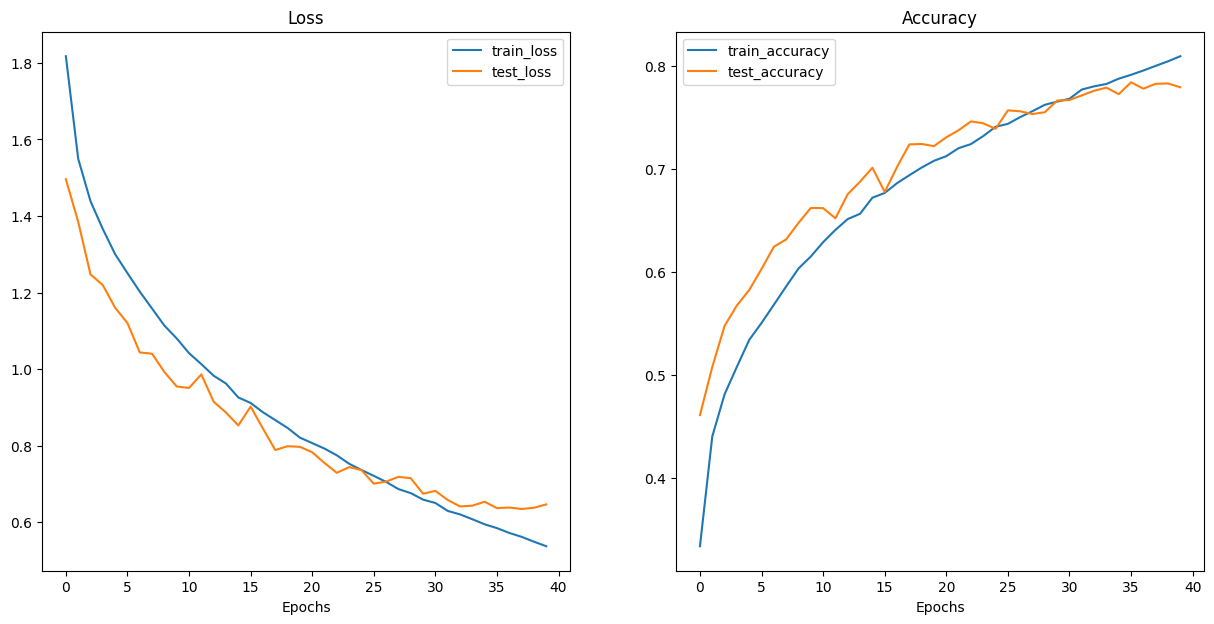

In [49]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)